In [1]:
import pandas as pd, numpy as np

trip_sheet = '/DATA/TripAnalysis/nextbike_trips.csv'

#before cleaning
trip_df = pd.read_csv(trip_sheet.lstrip('/'))
print(trip_df.head(5).to_string(index=False))
print(f"Length of the dataframe before cleaning: {len(trip_df)}")

trip_df = (
    pd.read_csv(trip_sheet.lstrip('/'))
      .pipe(lambda d: d.rename(columns={c: c.strip() for c in d.columns}))
      .assign(**{
          'Duration-Minutes': lambda d: pd.to_numeric(d['Duration-Minutes'], errors='coerce'),
          'Rental-Lat':       lambda d: pd.to_numeric(d['Rental-Lat'], errors='coerce'),
          'Rental-Lng':       lambda d: pd.to_numeric(d['Rental-Lng'], errors='coerce'),
          'Return-Lat':       lambda d: pd.to_numeric(d['Return-Lat'], errors='coerce'),
          'Return-Lng':       lambda d: pd.to_numeric(d['Return-Lng'], errors='coerce'),
      })
      .loc[lambda d: ~d.apply(lambda r: r.astype(str).str.contains('unbekannt', case=False).any(), axis=1)]
      .loc[lambda d: d['Duration-Minutes'] > 2]
      .loc[lambda d: ~((d['Rental-Lat'] == d['Return-Lat']) & (d['Rental-Lng'] == d['Return-Lng']))]
      .assign(**{
          'Rental-Time': lambda d: pd.to_datetime(d['Rental-Time'], errors='coerce'),
          'weekday_idx': lambda d: d['Rental-Time'].dt.weekday,
          'is_weekend':  lambda d: d['weekday_idx'] >= 5,
          'hour':        lambda d: d['Rental-Time'].dt.hour,
      })
      .reset_index(drop=True)
)

print(trip_df.head(5).to_string(index=False))
print(f"Length of the dataframe after cleaning: {len(trip_df)}")


 Bike-Number         Rental-Time        Rental-Type                                     Rental-Location  Rental-Lat  Rental-Lng         Return-Time        Return-Type                  Return-Location  Return-Lat  Return-Lng  Duration-Minutes   Movement-Type
      100245 2025-07-23 21:56:39 Station (virtuell)                            U Schlesisches Tor (Ost)   52.500794   13.442182 2025-07-23 22:08:17 Station (virtuell)        Elsenstraße/Harzer Straße   52.485136   13.449063              11.6 Station:Station
       13167 2025-07-23 20:22:59 Station (virtuell)                           Elsenstraße/Harzer Straße   52.485136   13.449063 2025-07-23 22:08:17 Station (virtuell) Modersohnstraße (Am Rudolfplatz)   52.502492   13.456503             105.3 Station:Station
       19766 2025-07-23 21:56:31 Station (physisch) Jelbi S+U Zoologischer Garten/Jebensstraße (CHA/JE)   52.506622   13.331480 2025-07-23 22:08:26 Station (virtuell)  Franklinstraße/Glutenbergstraße   52.518675   13.326239   

/var/folders/h5/zhw0n5ns1xggx80nhjzz4bs40000gn/T/ipykernel_9686/3922021772.py:32: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  berlin_geom = bezirke.unary_union


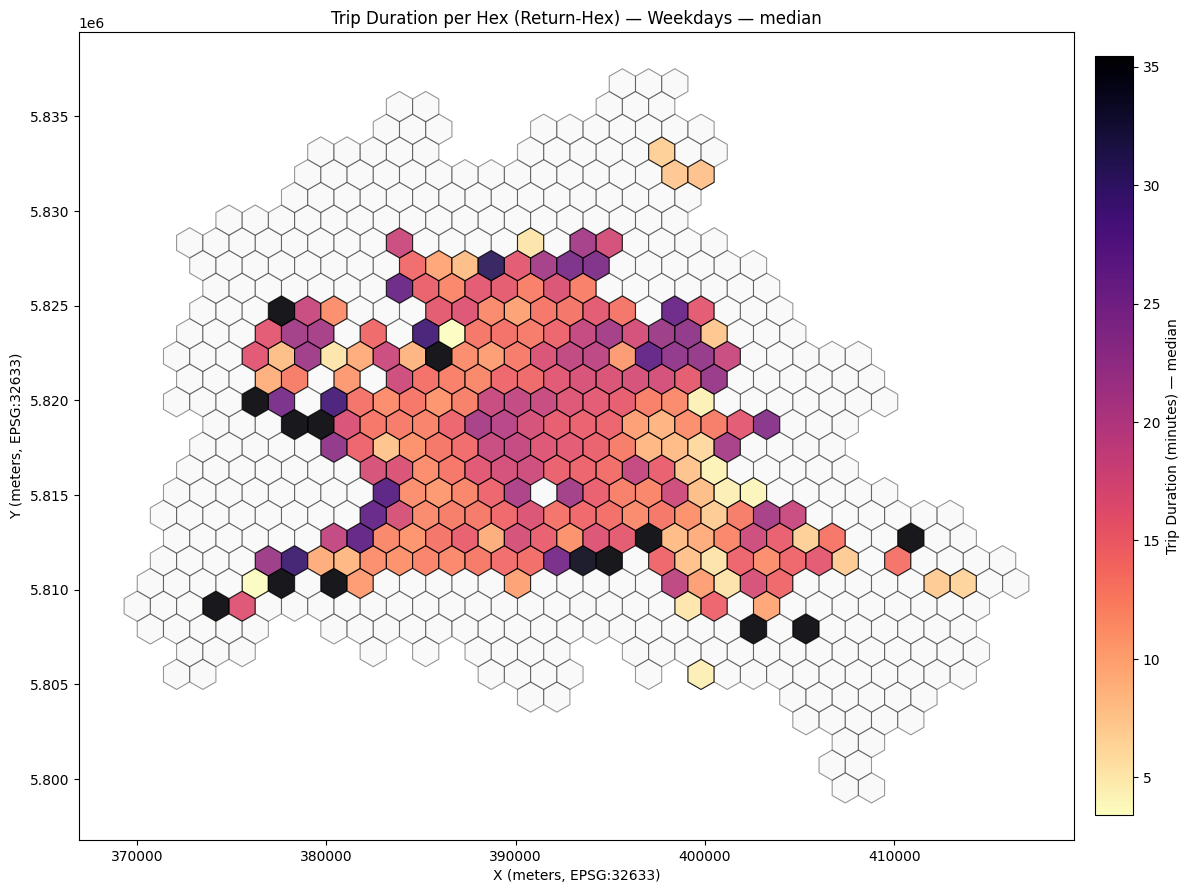

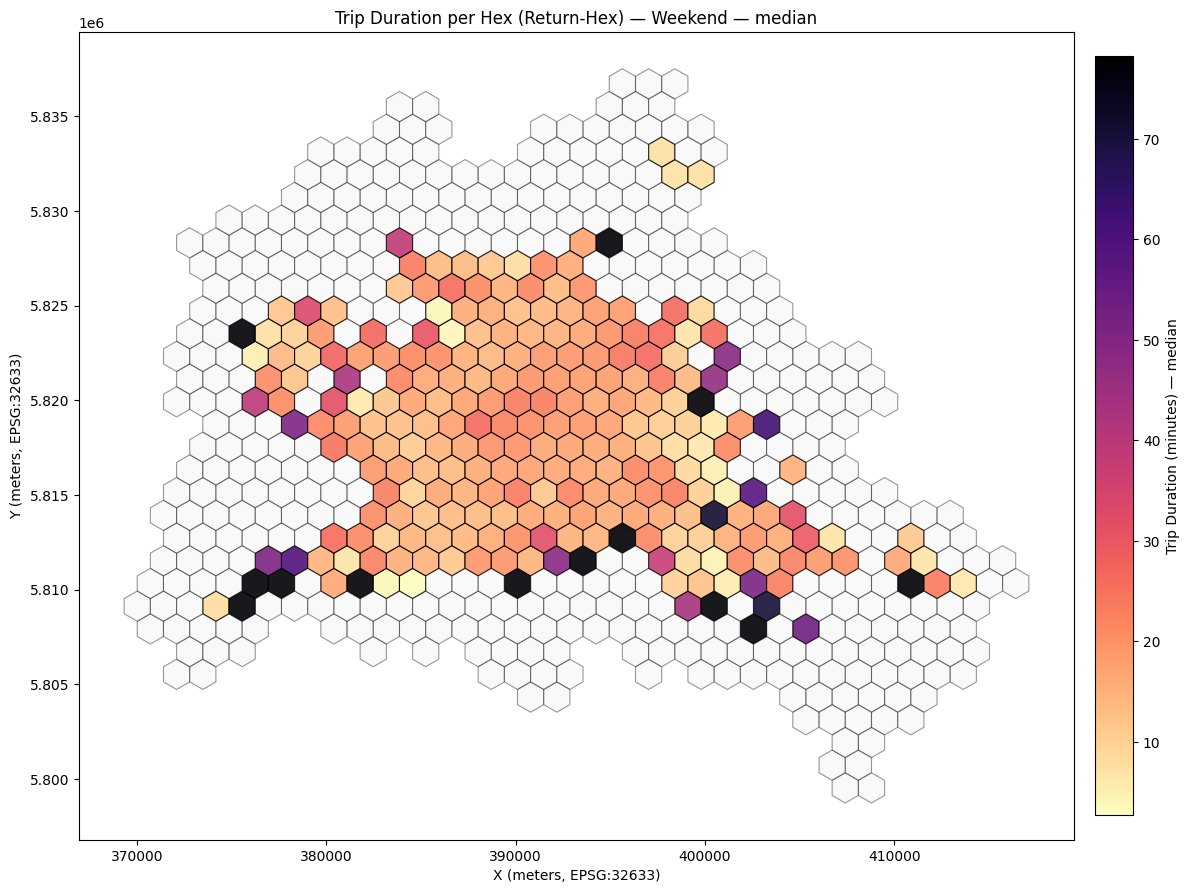

In [3]:
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import matplotlib as mpl

# ----------------------------
# Einstellungen
# ----------------------------
INPUT_PATH = "./DATA/TripAnalysis/bezirksgrenzen.geojson"

# Größe eines Hexagons: size = Radius (Mittelpunkt -> Ecke) in Metern
SIZE_METERS = 800.0

# Plot-Optionen
EDGE_COLOR = 'black'  # schwarzer Rand
LINE_WIDTH = 0.8
ALPHA = 0.9           # Füll-Deckkraft
CMAP_NAME = 'magma_r' # Farbskala

# Was soll aggregiert werden?
AGG_TARGET = 'return'     # 'return' (Ende im Hex) oder 'start' (Start im Hex)
AGG_STAT = 'median'       # 'median' | 'mean' | 'p95' (95. Perzentil)
USE_DAILY_AVG = False     # True: Tageswerte je Hex bilden und dann mitteln

# ----------------------------
# Berlin-Grenzen laden und in UTM projizieren
# ----------------------------
bezirke = gpd.read_file(INPUT_PATH).to_crs(32633)
berlin_geom = bezirke.unary_union
berlin_gs = gpd.GeoSeries([berlin_geom], crs=32633)
minx, miny, maxx, maxy = berlin_gs.total_bounds

# ----------------------------
# Hexgrid (pointy-top) erzeugen
# ----------------------------
dx = np.sqrt(3) * SIZE_METERS
dy = 1.5 * SIZE_METERS

def hex_corners_pointy(xc, yc, s):
    angles = np.deg2rad([30, 90, 150, 210, 270, 330, 30])
    return [(xc + s*np.cos(a), yc + s*np.sin(a)) for a in angles]

hex_centers = []
y = miny
row = 0
while y <= maxy + dy:
    x_offset = dx / 2.0 if (row % 2) else 0.0
    x = minx + x_offset
    while x <= maxx + dx:
        hex_centers.append((x, y))
        x += dx
    y += dy
    row += 1

hex_polys = [Polygon(hex_corners_pointy(x, y, SIZE_METERS)) for x, y in hex_centers]
hex_gdf = gpd.GeoDataFrame({'hex_id': np.arange(len(hex_polys))},
                           geometry=hex_polys, crs=32633)

# Auf Berlin begrenzen
hex_in = hex_gdf[hex_gdf.intersects(berlin_geom)].copy().reset_index(drop=True)
hex_in = hex_in[['hex_id', 'geometry']]

# ----------------------------
# Trips laden und in UTM projizieren
# Erwartet: trip_patterns_df mit Spalten:
#   Rental-Time, Rental-Lat, Rental-Lng, Return-Lat, Return-Lng, Duration-Minutes
# ----------------------------
df = trip_df.copy()

# Grundbereinigung
df['Rental-Time'] = pd.to_datetime(df['Rental-Time'], errors='coerce')
df['Duration-Minutes'] = pd.to_numeric(df['Duration-Minutes'], errors='coerce')
df = df.dropna(subset=['Rental-Time','Duration-Minutes','Rental-Lat','Rental-Lng','Return-Lat','Return-Lng']).copy()

df['weekday_idx'] = df['Rental-Time'].dt.weekday  # 0=Mon ... 6=Sun
df['is_weekend'] = df['weekday_idx'] >= 5

# GeoFrames für Start und Ende
gdf_start = gpd.GeoDataFrame(
    df[['Rental-Time','is_weekend','Duration-Minutes']].copy(),
    geometry=gpd.points_from_xy(df['Rental-Lng'], df['Rental-Lat']),
    crs=4326
).to_crs(32633)

gdf_end = gpd.GeoDataFrame(
    df[['Rental-Time','is_weekend','Duration-Minutes']].copy(),
    geometry=gpd.points_from_xy(df['Return-Lng'], df['Return-Lat']),
    crs=4326
).to_crs(32633)

# ----------------------------
# Funktion: Dauer-Kennzahl pro Hex berechnen
# ----------------------------
def duration_stat_per_hex(points_gdf, hex_gdf, agg_stat='median', use_daily_average=False):
    # Punkte dem Hex zuordnen
    pts = gpd.sjoin(points_gdf[['geometry','Rental-Time','Duration-Minutes']], hex_gdf, how='inner', predicate='within')
    pts = pts.rename(columns={'hex_id':'hid'}).drop(columns=['index_right'])

    if pts.empty:
        out = hex_gdf.copy()
        out['duration_stat'] = np.nan
        return out

    if use_daily_average:
        pts['date'] = pts['Rental-Time'].dt.date
        daily = pts.groupby(['date','hid'])['Duration-Minutes']
        if agg_stat == 'median':
            day_val = daily.median().reset_index(name='day_val')
        elif agg_stat == 'mean':
            day_val = daily.mean().reset_index(name='day_val')
        elif agg_stat == 'p95':
            day_val = daily.quantile(0.95).reset_index(name='day_val')
        else:
            raise ValueError("agg_stat muss 'median', 'mean' oder 'p95' sein.")
        # Tageswerte je Hex mitteln
        hex_stat = day_val.groupby('hid')['day_val'].mean().reset_index(name='duration_stat')
    else:
        grp = pts.groupby('hid')['Duration-Minutes']
        if agg_stat == 'median':
            hex_stat = grp.median().reset_index(name='duration_stat')
        elif agg_stat == 'mean':
            hex_stat = grp.mean().reset_index(name='duration_stat')
        elif agg_stat == 'p95':
            hex_stat = grp.quantile(0.95).reset_index(name='duration_stat')
        else:
            raise ValueError("agg_stat muss 'median', 'mean' oder 'p95' sein.")

    result = hex_gdf.merge(hex_stat, left_on='hex_id', right_on='hid', how='left') \
                    .drop(columns=['hid'])
    return result

# Wrapper für Start/Ende
def make_duration_layer(which='return', weekend=False, agg_stat=AGG_STAT, use_daily_average=USE_DAILY_AVG):
    pts = gdf_end if which=='return' else gdf_start
    pts = pts[pts['is_weekend']==weekend].copy()
    layer = duration_stat_per_hex(pts, hex_in, agg_stat=agg_stat, use_daily_average=use_daily_average)
    return layer

# ----------------------------
# Karten erzeugen: Median-Dauer (End-Hex) für Weekday/Weekend
# ----------------------------
plot_wd = make_duration_layer(which=AGG_TARGET, weekend=False, agg_stat=AGG_STAT, use_daily_average=USE_DAILY_AVG)
plot_we = make_duration_layer(which=AGG_TARGET, weekend=True,  agg_stat=AGG_STAT, use_daily_average=USE_DAILY_AVG)

# ----------------------------
# Plot-Funktion mit Colorbar
# ----------------------------
def plot_hex_duration(gdf_plot, title):
    fig, ax = plt.subplots(figsize=(12, 12))
    vals = gdf_plot['duration_stat']
    # Norm robust (ignoriere NaN)
    vmin = np.nanmin(vals)
    vmax = np.nanpercentile(vals, 95)  # kappen auf 95%-Perzentil gegen Ausreißer
    if not np.isfinite(vmin) or not np.isfinite(vmax):
        vmin, vmax = 0.0, 1.0
    norm = Normalize(vmin=vmin, vmax=vmax)
    cmap = plt.get_cmap(CMAP_NAME)

    gdf_plot.plot(
        ax=ax, column='duration_stat', cmap=cmap, linewidth=LINE_WIDTH,
        edgecolor=EDGE_COLOR, alpha=ALPHA, norm=norm, missing_kwds={"color": "#f0f0f0", "edgecolor": EDGE_COLOR, "alpha": 0.4}
    )

    sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax, fraction=0.036, pad=0.02)
    cbar.set_label(f"Trip Duration (minutes) — {AGG_STAT}")

    ax.set_title(title)
    ax.set_xlabel("X (meters, EPSG:32633)")
    ax.set_ylabel("Y (meters, EPSG:32633)")
    ax.set_aspect('equal', adjustable='box')
    plt.tight_layout()
    plt.show()

# ----------------------------
# Plots
# ----------------------------
label_loc = "Return-Hex" if AGG_TARGET=='return' else "Start-Hex"
plot_hex_duration(plot_wd, f"Trip Duration per Hex ({label_loc}) — Weekdays — {AGG_STAT}")
plot_hex_duration(plot_we, f"Trip Duration per Hex ({label_loc}) — Weekend — {AGG_STAT}")


/var/folders/h5/zhw0n5ns1xggx80nhjzz4bs40000gn/T/ipykernel_9686/1420491190.py:31: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  berlin_geom = bezirke.unary_union


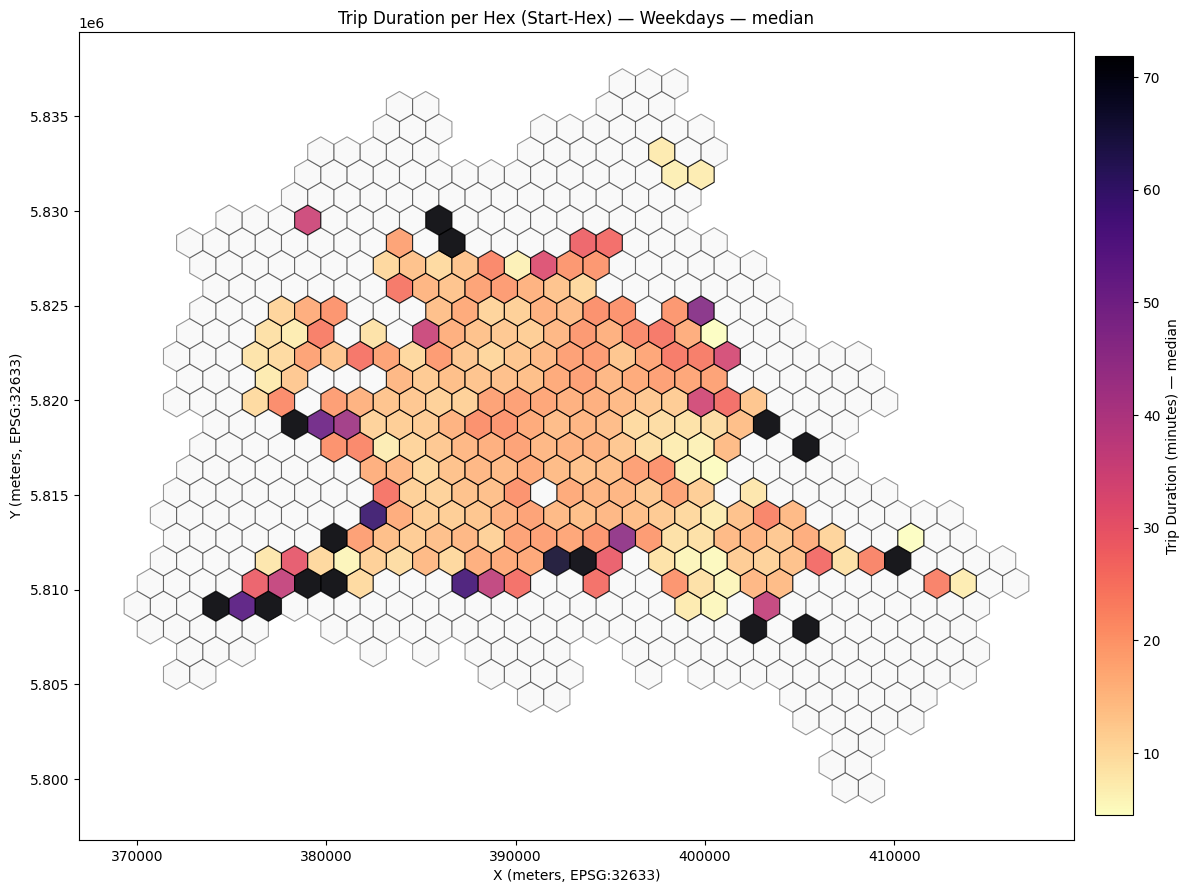

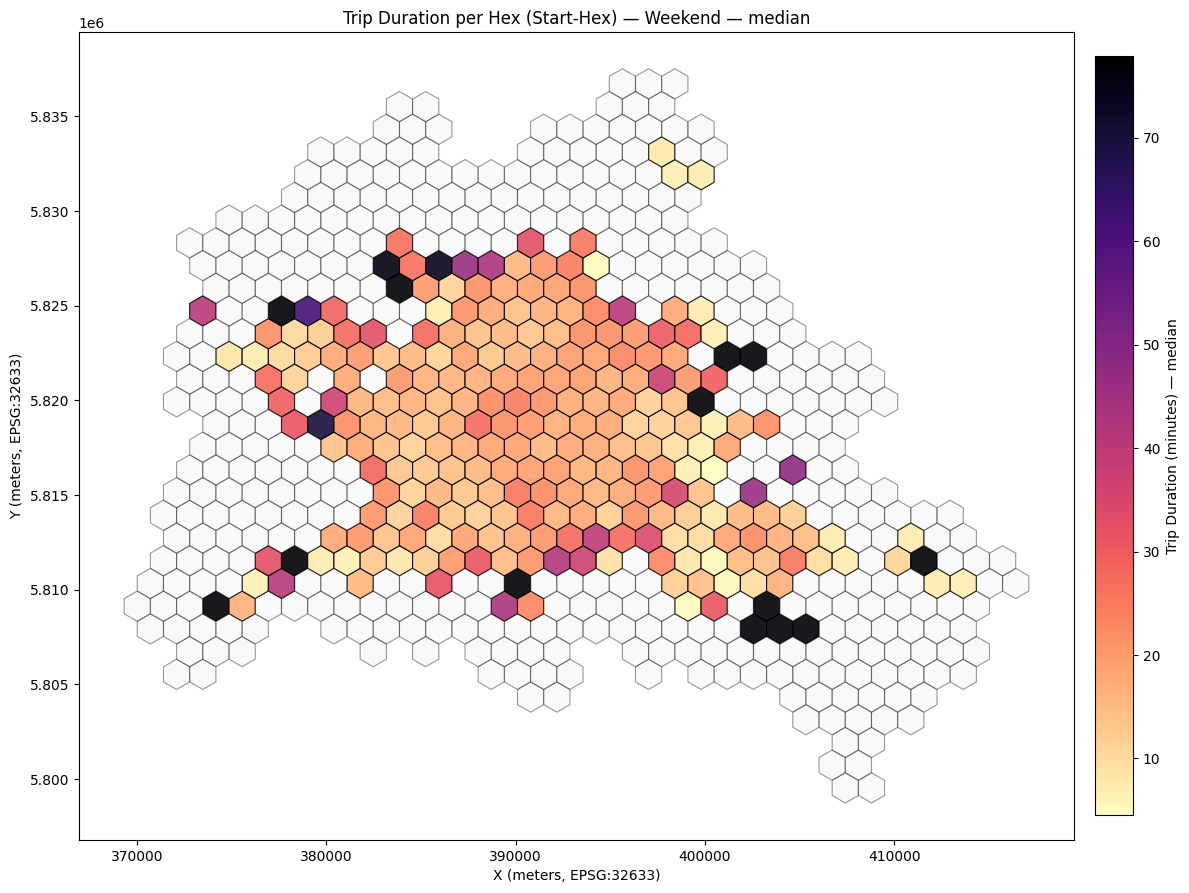

In [5]:
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import matplotlib as mpl

# ----------------------------
# Einstellungen
# ----------------------------
INPUT_PATH = "./DATA/TripAnalysis/bezirksgrenzen.geojson"

# Größe eines Hexagons: size = Radius (Mittelpunkt -> Ecke) in Metern
SIZE_METERS = 800.0

# Plot-Optionen
EDGE_COLOR = 'black'   # schwarzer Rand
LINE_WIDTH = 0.8
ALPHA = 0.9            # Füll-Deckkraft
CMAP_NAME = 'magma_r'  # Farbskala

# Aggregations-Parameter
AGG_STAT = 'median'     # 'median' | 'mean' | 'p95'
USE_DAILY_AVG = False   # True: Tageswerte je Hex bilden und dann mitteln

# ----------------------------
# Berlin-Grenzen laden und in UTM projizieren
# ----------------------------
bezirke = gpd.read_file(INPUT_PATH).to_crs(32633)
berlin_geom = bezirke.unary_union
berlin_gs = gpd.GeoSeries([berlin_geom], crs=32633)
minx, miny, maxx, maxy = berlin_gs.total_bounds

# ----------------------------
# Hexgrid (pointy-top) erzeugen
# ----------------------------
dx = np.sqrt(3) * SIZE_METERS
dy = 1.5 * SIZE_METERS

def hex_corners_pointy(xc, yc, s):
    angles = np.deg2rad([30, 90, 150, 210, 270, 330, 30])
    return [(xc + s*np.cos(a), yc + s*np.sin(a)) for a in angles]

hex_centers = []
y = miny
row = 0
while y <= maxy + dy:
    x_offset = dx / 2.0 if (row % 2) else 0.0
    x = minx + x_offset
    while x <= maxx + dx:
        hex_centers.append((x, y))
        x += dx
    y += dy
    row += 1

hex_polys = [Polygon(hex_corners_pointy(x, y, SIZE_METERS)) for x, y in hex_centers]
hex_gdf = gpd.GeoDataFrame({'hex_id': np.arange(len(hex_polys))},
                           geometry=hex_polys, crs=32633)

# Auf Berlin begrenzen
hex_in = hex_gdf[hex_gdf.intersects(berlin_geom)].copy().reset_index(drop=True)
hex_in = hex_in[['hex_id', 'geometry']]

# ----------------------------
# Trips laden und in UTM projizieren
# Erwartet: trip_patterns_df mit Spalten:
#   Rental-Time, Rental-Lat, Rental-Lng, Return-Lat, Return-Lng, Duration-Minutes
# ----------------------------
df = trip_df.copy()

# Grundbereinigung
df['Rental-Time'] = pd.to_datetime(df['Rental-Time'], errors='coerce')
df['Duration-Minutes'] = pd.to_numeric(df['Duration-Minutes'], errors='coerce')
df = df.dropna(subset=['Rental-Time','Duration-Minutes','Rental-Lat','Rental-Lng','Return-Lat','Return-Lng']).copy()

df['weekday_idx'] = df['Rental-Time'].dt.weekday  # 0=Mon ... 6=Sun
df['is_weekend'] = df['weekday_idx'] >= 5

# GeoFrames für Start (für Start-Hex Aggregation maßgeblich)
gdf_start = gpd.GeoDataFrame(
    df[['Rental-Time','is_weekend','Duration-Minutes']].copy(),
    geometry=gpd.points_from_xy(df['Rental-Lng'], df['Rental-Lat']),
    crs=4326
).to_crs(32633)

# ----------------------------
# Funktion: Dauer-Kennzahl pro Start-Hex berechnen
# ----------------------------
def duration_stat_per_hex(points_gdf, hex_gdf, agg_stat='median', use_daily_average=False):
    # Punkte dem Hex zuordnen
    pts = gpd.sjoin(points_gdf[['geometry','Rental-Time','Duration-Minutes']], hex_gdf, how='inner', predicate='within')
    pts = pts.rename(columns={'hex_id':'hid'}).drop(columns=['index_right'])

    if pts.empty:
        out = hex_gdf.copy()
        out['duration_stat'] = np.nan
        return out

    if use_daily_average:
        pts['date'] = pts['Rental-Time'].dt.date
        daily = pts.groupby(['date','hid'])['Duration-Minutes']
        if agg_stat == 'median':
            day_val = daily.median().reset_index(name='day_val')
        elif agg_stat == 'mean':
            day_val = daily.mean().reset_index(name='day_val')
        elif agg_stat == 'p95':
            day_val = daily.quantile(0.95).reset_index(name='day_val')
        else:
            raise ValueError("agg_stat muss 'median', 'mean' oder 'p95' sein.")
        # Tageswerte je Hex mitteln
        hex_stat = day_val.groupby('hid')['day_val'].mean().reset_index(name='duration_stat')
    else:
        grp = pts.groupby('hid')['Duration-Minutes']
        if agg_stat == 'median':
            hex_stat = grp.median().reset_index(name='duration_stat')
        elif agg_stat == 'mean':
            hex_stat = grp.mean().reset_index(name='duration_stat')
        elif agg_stat == 'p95':
            hex_stat = grp.quantile(0.95).reset_index(name='duration_stat')
        else:
            raise ValueError("agg_stat muss 'median', 'mean' oder 'p95' sein.")

    result = hex_gdf.merge(hex_stat, left_on='hex_id', right_on='hid', how='left') \
                    .drop(columns=['hid'])
    return result

# Wrapper für Start/Weekend-Filter
def make_duration_layer_start(weekend=False, agg_stat=AGG_STAT, use_daily_average=USE_DAILY_AVG):
    pts = gdf_start[gdf_start['is_weekend']==weekend].copy()
    layer = duration_stat_per_hex(pts, hex_in, agg_stat=agg_stat, use_daily_average=use_daily_average)
    return layer

# ----------------------------
# Karten erzeugen: Median-Dauer (Start-Hex) für Weekday/Weekend
# ----------------------------
plot_wd = make_duration_layer_start(weekend=False, agg_stat=AGG_STAT, use_daily_average=USE_DAILY_AVG)
plot_we = make_duration_layer_start(weekend=True,  agg_stat=AGG_STAT, use_daily_average=USE_DAILY_AVG)

# ----------------------------
# Plot-Funktion mit Colorbar
# ----------------------------
def plot_hex_duration(gdf_plot, title):
    fig, ax = plt.subplots(figsize=(12, 12))
    vals = gdf_plot['duration_stat']
    # Norm robust (ignoriere NaN, kappen auf 95. Perzentil gegen Ausreißer)
    finite_vals = vals[np.isfinite(vals)]
    if finite_vals.empty:
        vmin, vmax = 0.0, 1.0
    else:
        vmin = np.nanmin(finite_vals)
        vmax = np.nanpercentile(finite_vals, 95)
        if vmin == vmax:
            vmax = vmin + 1.0
    norm = Normalize(vmin=vmin, vmax=vmax)
    cmap = plt.get_cmap(CMAP_NAME)

    gdf_plot.plot(
        ax=ax, column='duration_stat', cmap=cmap, linewidth=LINE_WIDTH,
        edgecolor=EDGE_COLOR, alpha=ALPHA, norm=norm,
        missing_kwds={"color": "#f0f0f0", "edgecolor": EDGE_COLOR, "alpha": 0.4}
    )

    sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax, fraction=0.036, pad=0.02)
    cbar.set_label(f"Trip Duration (minutes) — {AGG_STAT}")

    ax.set_title(title)
    ax.set_xlabel("X (meters, EPSG:32633)")
    ax.set_ylabel("Y (meters, EPSG:32633)")
    ax.set_aspect('equal', adjustable='box')
    plt.tight_layout()
    plt.show()

# ----------------------------
# Plots
# ----------------------------
plot_hex_duration(plot_wd, f"Trip Duration per Hex (Start-Hex) — Weekdays — {AGG_STAT}")
plot_hex_duration(plot_we, f"Trip Duration per Hex (Start-Hex) — Weekend — {AGG_STAT}")


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Voraussetzung: trip_patterns_df mit Spalten:
# Rental-Time (datetime/str), Duration-Minutes (numeric)

df = trip_df.copy()

# Aufbereiten
df['Rental-Time'] = pd.to_datetime(df['Rental-Time'], errors='coerce')
df['Duration-Minutes'] = pd.to_numeric(df['Duration-Minutes'], errors='coerce')
df = df.dropna(subset=['Rental-Time','Duration-Minutes'])

# Grundfeatures
df['hour'] = df['Rental-Time'].dt.hour
df['weekday'] = df['Rental-Time'].dt.weekday
df['is_weekend'] = df['weekday'] >= 5

# Funktion: Aggregation je Stunde
def hourly_stats(d):
    g = d.groupby('hour')['Duration-Minutes']
    out = g.agg(
        mean='mean',
        median='median',
        p25=lambda x: np.percentile(x, 25),
        p75=lambda x: np.percentile(x, 75),
        n='size'
    ).reset_index()
    return out

wd = df[~df['is_weekend']]
we = df[df['is_weekend']]

stats_wd = hourly_stats(wd)
stats_we = hourly_stats(we)

# Optional: gleitender Mittelwert (über 3 Stunden) zur Glättung
def add_sma(s, win=3):
    return s.rolling(win=win, center=True, min_periods=1).mean()

stats_wd['mean_sma'] = add_sma(stats_wd['mean'])
stats_we['mean_sma'] = add_sma(stats_we['mean'])

# Plot 1: Mean + IQR-Band je Stunde, Weekday vs Weekend
fig, ax = plt.subplots(figsize=(10,5))

# Weekday
ax.plot(stats_wd['hour'], stats_wd['mean'], color='#1f77b4', label='Weekday mean')
ax.fill_between(stats_wd['hour'], stats_wd['p25'], stats_wd['p75'], color='#1f77b4', alpha=0.15, label='Weekday IQR')
# Weekend
ax.plot(stats_we['hour'], stats_we['mean'], color='#d62728', label='Weekend mean')
ax.fill_between(stats_we['hour'], stats_we['p25'], stats_we['p75'], color='#d62728', alpha=0.15, label='Weekend IQR')

# Glättung (gestrichelt)
ax.plot(stats_wd['hour'], stats_wd['mean_sma'], color='#1f77b4', linestyle='--', alpha=0.9, label='Weekday mean (SMA)')
ax.plot(stats_we['hour'], stats_we['mean_sma'], color='#d62728', linestyle='--', alpha=0.9, label='Weekend mean (SMA)')

ax.set_title('Average trip duration by hour (with IQR band)')
ax.set_xlabel('Hour of day'); ax.set_ylabel('Minutes')
ax.set_xticks(range(0,24,1)); ax.grid(True, alpha=0.2)
ax.legend(ncol=2)
plt.tight_layout(); plt.show()

# Plot 2: Median je Stunde (robust gegenüber Ausreißern)
fig, ax = plt.subplots(figsize=(10,4))
ax.plot(stats_wd['hour'], stats_wd['median'], color='#1f77b4', label='Weekday median')
ax.plot(stats_we['hour'], stats_we['median'], color='#d62728', label='Weekend median')
ax.set_title('Median trip duration by hour')
ax.set_xlabel('Hour of day'); ax.set_ylabel('Minutes')
ax.set_xticks(range(0,24,1)); ax.grid(True, alpha=0.2); ax.legend()
plt.tight_layout(); plt.show()

# Optional: Morning vs Evening Peak direkte Gegenüberstellung
def in_bin(h, lo, hi): return (h>=lo) & (h<=hi)
bins = {
    'Morning (6-10)': (6,10),
    'Midday (11-15)': (11,15),
    'Evening (16-20)': (16,20),
}
comp_rows = []
for label, (lo,hi) in bins.items():
    for tag, subset in [('Weekday', wd), ('Weekend', we)]:
        sub = subset[subset['hour'].between(lo,hi)]
        comp_rows.append({
            'bin': label,
            'group': tag,
            'mean': sub['Duration-Minutes'].mean(),
            'median': sub['Duration-Minutes'].median(),
            'n': len(sub)
        })
comp = pd.DataFrame(comp_rows)

# Balken: Mittelwert nach Zeitfenster
fig, ax = plt.subplots(figsize=(8,4))
pivot_mean = comp.pivot(index='bin', columns='group', values='mean')
pivot_mean[['Weekday','Weekend']].plot(kind='bar', ax=ax, color=['#1f77b4','#d62728'])
ax.set_title('Average duration by time window'); ax.set_ylabel('Minutes'); ax.grid(axis='y', alpha=0.2)
plt.tight_layout(); plt.show()

# Ausgabe der Kerndaten
print("Weekday hourly stats (head):")
print(stats_wd.head().to_string(index=False))
print("\nWeekend hourly stats (head):")
print(stats_we.head().to_string(index=False))
print("\nTime-window comparison (mean/median, counts):")
print(comp.to_string(index=False))


TypeError: NDFrame.rolling() got an unexpected keyword argument 'win'